In [97]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [98]:
pcd = o3d.io.read_point_cloud("models/house.ply")
# o3d.visualization.draw_geometries([pcd])

In [99]:
np.asarray(pcd.points[5000: 5010])

array([[-15.8419 ,   4.49058,  -1.4939 ],
       [-16.0329 ,   3.90658,  -1.5289 ],
       [-15.6029 ,   3.20558,  -1.5159 ],
       [-16.2339 ,   2.99658,  -1.5709 ],
       [-15.9519 ,   2.60458,  -1.5479 ],
       [-15.5009 ,   2.65258,  -1.4789 ],
       [-16.0729 ,   2.88058,  -1.5409 ],
       [-15.3399 ,   4.24058,  -1.4379 ],
       [-16.2259 ,   2.58558,  -1.5409 ],
       [-15.8809 ,   4.60458,  -1.4679 ]])

In [100]:
pcd = pcd.voxel_down_sample(voxel_size=0.1)
point_cloud_in_numpy = np.asarray(pcd.points)

In [101]:
len(point_cloud_in_numpy)

71118

# NDT

In [108]:
s = 0.3
te = 0.04
A = point_cloud_in_numpy // s

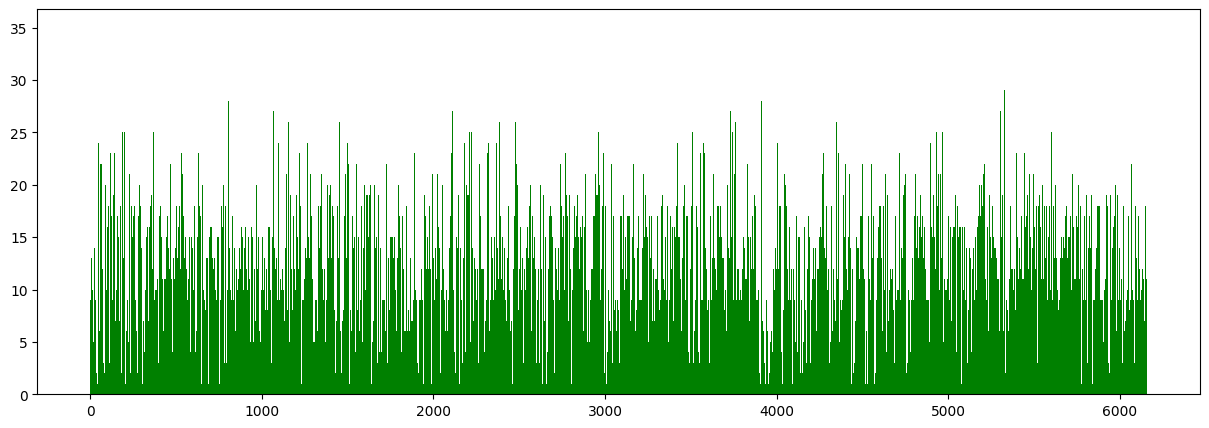

In [109]:
unique,counts=np.unique(A,axis=0, return_counts=True)
plt.figure(figsize=(15,5))
plt.bar(range(0, len(counts)), counts, width=1.5, color='g')
plt.show()

In [110]:
def IRLS_find_norm(points, cov):
    lambd, e = np.linalg.eig(cov)
    e = e.T
    o = lambd.argsort()
    lambd = lambd[o]
    e = e[o]
    gamma = 1e-6
    k_w = 2.985
    n = e[0]
    g = np.mean(points, axis = 0)
    X_prev = np.zeros(3)
    for i in range(100):
        n_old = n
        r = (points - g) @ n
        w = np.exp(-(r ** 2 / k_w ** 2))
        X_k = np.average(points - g - X_prev, axis=0, weights=w)
        vec = (points - g - X_k)
        X_prev = X_k
        C = (vec.T * w) @ vec
        w, v = np.linalg.eig(C)
        v = v.T
        o = w.argsort()
        w = w[o]
        v = v[o]
        n = v[0]
        convg = np.linalg.norm(n_old - n) / np.linalg.norm(n_old)
        if convg < gamma:
            break
    return n

In [111]:
mu = []
normals = []
Q = []
Q_points = []
P = []
for ind, i in tqdm(list(enumerate(unique))):
    this_cell = np.array(point_cloud_in_numpy[np.where(np.prod(A == i, axis = -1))])
    if len(this_cell) <= 3:
        P.append(this_cell)
        continue
    mu.append(np.mean(this_cell))
    cov = np.cov(np.array(this_cell).T)
    #print("cov = ", cov)
    w, v = np.linalg.eig(cov)
    v = v.T
    o = w.argsort()
    w = w[o]
    v = v[o]
    #print("values = ", w)
    if abs(w[0] / w[1]) <= te:
        Q.append(i)
        Q_points.append(this_cell)
        normals.append(IRLS_find_norm(this_cell, cov))
    else:
        P.append(this_cell)
P = np.concatenate(P)

  0%|          | 0/6160 [00:00<?, ?it/s]

In [112]:
len(Q)

2535

In [113]:
Q_indices = {}
for index, cell_index in enumerate(Q):
    Q_indices[tuple(cell_index)] = index

In [114]:
# Q_points = np.array(Q_points)
normals = np.array(normals)
print(Q[0])
print(np.shape(normals), len(Q_points))

[-55.   8.  -6.]
(2535, 3) 2535


In [115]:
def create_circle_mesh(center, normal, radius, num_points=12):
    mesh = o3d.geometry.TriangleMesh()
    x_axis = np.array([1, 0, 0])
    if np.abs(normal.dot(x_axis)) < 0.1:
        x_axis = np.array([0, 1, 0])
    u = np.cross(normal, x_axis)
    u = u / np.linalg.norm(u)
    v = np.cross(normal, u)
    v = v / np.linalg.norm(v)

    # Generate points on a circle in 2D coordinates
    angles = np.linspace(0, 2*np.pi, num_points+1)[:-1]
    points_2d = radius * np.column_stack((np.cos(angles), np.sin(angles)))

    # Convert points to 3D coordinates
    circle_points = [center + points_2d[i,0]*u + points_2d[i,1]*v for i in range(num_points)]

    mesh.vertices = o3d.utility.Vector3dVector(circle_points)
    mesh.vertices.append(center)

    # Add faces connecting center to circle points
    for i in range(num_points):
        face = [i, (i+1) % num_points, num_points]
        mesh.triangles.append(face)
        face = [(i+1) % num_points, i, num_points]
        mesh.triangles.append(face)


    mesh.compute_vertex_normals()
    return mesh

In [116]:
color = [1.0, 0.5, 0.0] # orange color
threshold = 0.3
radius = s / 3
neighbors = [[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]]


In [117]:
meshes = []
for i in range(len(Q_points)):
    center = np.mean(Q_points[i], axis=0)
    normal = normals[i]
    mesh = create_circle_mesh(center, normal, radius, num_points=12)
    mesh.paint_uniform_color(color)
    meshes.append(mesh)

o3d.visualization.draw_geometries(meshes)

In [118]:
meshes = []
for i in range(len(Q_points)):
    center = np.mean(Q_points[i], axis=0)
    normal = normals[i]

    for neigh_move in neighbors:
        neigh_cell_index = tuple((center // s) + neigh_move)
        if neigh_cell_index not in Q_indices:
            continue

        index = Q_indices[neigh_cell_index]
        neighbor, neighbor_normal = np.mean(Q_points[index], axis=0), normals[index]
        angle = np.arccos(np.dot(normal, neighbor_normal))
        if angle < threshold:
            line_set = o3d.geometry.LineSet()
            line_set.points = o3d.utility.Vector3dVector([center, neighbor])
            line_set.lines = o3d.utility.Vector2iVector([[0, 1]])
            line_set.colors = o3d.utility.Vector3dVector([color])
            meshes.append(line_set)

# meshes.append(pcd)
o3d.visualization.draw_geometries(meshes)

In [119]:
Q_old = Q
P_old = P
Q_points_old = Q_points
normals_old = normals

# RANSAC

In [120]:
def get_remained_array(arr, bool_mask):
    if len(arr) != len(bool_mask):
        raise ValueError("Array and boolean mask should have the same size: %d != %d" % (len(arr), len(bool_mask)))

    result = []
    for i, value in enumerate(bool_mask):
        if not value:
            continue
        result.append(arr[i])
    return result

In [121]:
def plane(Q, P, Q_points, normals):
    k_max = 50
    nu = 0.95
    delta_d = 0.4
    n = 0
    delta_theta = 0.25
    k = 0
    Psi = np.zeros(len(Q), dtype=bool)
    Psi_size = 0
    Psi_points = []
    k = 1
    while k < k_max:
        c = np.random.choice(range(0, len(Q)))
        cell = Q[c]
        points = Q_points[c]
        gk = np.mean(points, axis=0)
        nk = normals[c]
        Ik = np.zeros(len(Q), dtype=bool)
        cnt = 0
        Ik_points = []
        for i, v in enumerate(Q):
            g_i = np.mean(Q_points[i], axis=0)
            n_i = normals[i]
            d_i = np.dot((g_i - gk), nk) / np.linalg.norm(nk)
            theta_i = 1 - np.abs(np.dot(nk, n_i)) / (np.linalg.norm(nk) * np.linalg.norm(n_i))
            if np.abs(d_i) < delta_d and theta_i < delta_theta:
                Ik[i] = True
                cnt += 1
                Ik_points.extend(Q_points[i])
        if cnt > Psi_size:
            Psi = Ik
            Psi_points = Ik_points
            Psi_size = cnt
            n = nk
            g = gk
            Pn = Psi_size / len(Q)
            k_max = int(np.ceil(np.log(1 - nu) / np.log(1 - Pn)))
        k += 1

    P_mask = np.zeros(len(P), dtype=bool)
    for j, i in enumerate(P):
        d_i = np.inner(i - g, n) / np.linalg.norm(n)
        if np.abs(d_i) < delta_d:
            P_mask[j] = True
            Psi_points.append(i)
    return n, g, np.array(Psi_points), get_remained_array(Q, ~Psi), get_remained_array(Q_points, ~Psi), get_remained_array(P, ~P_mask), get_remained_array(normals, ~Psi)

In [122]:
new_pcd = o3d.geometry.PointCloud()

Q = Q_old
P = P_old
Q_points = Q_points_old
normals = normals_old

planes_points = np.zeros((0, 3))
planes_colors = np.zeros((0, 3))
planes_normals = np.zeros((0, 3))
final_f = []

for i in tqdm(range(100)):
    n, g, Psi_points, Q, Q_points, P, normals = plane(Q, P, Q_points, normals)
    print(n)
#     print(g)
    print(len(Psi_points))
    print(max(Psi_points[:, 2]), min(Psi_points[:, 2]))
    if len(Psi_points) < 100:
        break
    planes_points = np.concatenate((planes_points, Psi_points))
    planes_colors = np.concatenate((planes_colors, np.repeat(np.random.random(3).reshape(1, 3), len(Psi_points), axis = 0)))
    planes_normals_normals = np.concatenate((planes_normals, [n] * len(Psi_points)))

new_pcd.points = o3d.utility.Vector3dVector(planes_points)
new_pcd.colors = o3d.utility.Vector3dVector(planes_colors)
o3d.visualization.draw_geometries([new_pcd])

  0%|          | 0/100 [00:00<?, ?it/s]

[0.01781653 0.03791323 0.99912219]
25319
-0.5505858181818182 -1.6494
[0.01114046 0.0064865  0.9999169 ]
7611
-0.15543525000000002 -0.882904
[-9.52282728e-01  3.05216966e-01 -4.56828689e-04]
5043
1.9461 -1.3643800000000001
[-0.95710512  0.2682909   0.10940653]
6583
1.9471 -1.1920111111111111
[-0.27983694 -0.96003652 -0.00460071]
4142
1.9461 -1.3942333333333332
[-0.31610446 -0.9486008   0.01531332]
4453
1.9462578947368423 -1.4707309859154936
[-0.04952288 -0.02070424 -0.99855837]
1519
-1.2049344827586208 -1.5269000000000001
[-0.04725836  0.01269444  0.99880203]
4159
0.552596 -0.2714616923076923
[-0.94279441  0.31323365  0.11411999]
2176
1.9461 -0.5912116923076922
[-2.84598805e-01 -9.58646487e-01 -6.58515904e-04]
3060
1.9471 -0.8450468571428571
[ 0.08478481 -0.00345051  0.99639331]
1588
1.9471 1.0964548387096775
[-0.96923179  0.24593011 -0.01039812]
979
1.9196428571428572 -0.5457611428571428
[0.00585549 0.10121167 0.99484768]
1544
1.4766135135135137 0.1357997037037037
[-0.11210214 -0.99299

In [123]:
o3d.io.write_point_cloud("models/house_ndt_result.ply", new_pcd)

True

In [124]:
retrieved_pcd = o3d.io.read_point_cloud("models/house_ndt_result.ply")
o3d.visualization.draw_geometries([retrieved_pcd])